In [11]:

import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:

# Load the dataset
data = pd.read_csv('100k_a.csv', header=None)

# Rename the columns
data.columns = ['User ID', 'Stream ID', 'Streamer Username', 'Time Start', 'Time Stop']

# Convert 'Time Start' and 'Time Stop' to watch duration in minutes
data['Watch Duration'] = (data['Time Stop'] - data['Time Start']) * 10


In [13]:

# Group the data by 'User ID' and 'Streamer Username' and sum the watch durations
grouped_data = data.groupby(['User ID', 'Streamer Username'])['Watch Duration'].sum().reset_index()

# Convert 'User ID' and 'Streamer Username' to categorical
grouped_data['User ID'] = grouped_data['User ID'].astype("category")
grouped_data['Streamer Username'] = grouped_data['Streamer Username'].astype("category")


In [14]:

# Create the sparse matrix using compressed sparse row format
sparse_matrix = csr_matrix((grouped_data['Watch Duration'], 
                            (grouped_data['User ID'].cat.codes, 
                             grouped_data['Streamer Username'].cat.codes)))

# Normalize the sparse matrix
normalized_sparse_matrix = normalize(sparse_matrix, norm='l2', axis=1)


In [15]:

# Compute cosine similarity
similarity_matrix = cosine_similarity(normalized_sparse_matrix, dense_output=False)


In [16]:

# Create get rec funciton
def get_recommendations_with_scores(user_id, data, similarity_matrix, top_n=5):
    if user_id not in data['User ID'].values:
        return "User ID not found."

    # Convert user ID to the corresponding index in the matrix
    user_idx = data[data['User ID'] == user_id]['User ID'].astype("category").cat.codes.iloc[0]

    # Get similarity scores for the user and sort them
    user_similarity_scores = similarity_matrix[user_idx].toarray().flatten()
    sorted_indices = user_similarity_scores.argsort()[::-1]

    # Get top N recommendations
    top_similar_users_indices = sorted_indices[1:top_n + 1]  # Skip the first one as it's the user itself
    top_similar_users = data['User ID'].astype("category").cat.categories[top_similar_users_indices]
    top_similarity_scores = user_similarity_scores[top_similar_users_indices]

    # Combine user IDs with their similarity scores
    recommendations_with_scores = list(zip(top_similar_users, top_similarity_scores))

    return recommendations_with_scores


In [17]:

# Get the first ten unique user IDs from the dataset
first_ten_user_ids = data['User ID'].unique()[:10]

# Iterate over each user ID and get recommendations with similarity scores
for chosen_user_id in first_ten_user_ids:
    recommendations_with_scores = get_recommendations_with_scores(chosen_user_id, grouped_data, similarity_matrix)
    
    # Print recommendations and similarity scores for each user
    print(f"Recommendations for User ID {chosen_user_id} with Similarity Scores:")
    for user, score in recommendations_with_scores:
        print(f"User ID: {user}, Similarity Score: {score:.2f}")
    print("\n")


Recommendations for User ID 1 with Similarity Scores:
User ID: 35117, Similarity Score: 0.86
User ID: 83083, Similarity Score: 0.86
User ID: 68295, Similarity Score: 0.86
User ID: 65920, Similarity Score: 0.86
User ID: 25764, Similarity Score: 0.86


Recommendations for User ID 2 with Similarity Scores:
User ID: 22020, Similarity Score: 0.96
User ID: 36441, Similarity Score: 0.96
User ID: 31755, Similarity Score: 0.96
User ID: 50581, Similarity Score: 0.96
User ID: 66248, Similarity Score: 0.95


Recommendations for User ID 3 with Similarity Scores:
User ID: 61370, Similarity Score: 0.82
User ID: 41179, Similarity Score: 0.81
User ID: 18440, Similarity Score: 0.73
User ID: 36298, Similarity Score: 0.64
User ID: 8411, Similarity Score: 0.52


Recommendations for User ID 4 with Similarity Scores:
User ID: 56949, Similarity Score: 0.81
User ID: 95528, Similarity Score: 0.70
User ID: 64388, Similarity Score: 0.62
User ID: 88236, Similarity Score: 0.62
User ID: 79368, Similarity Score: 0.60

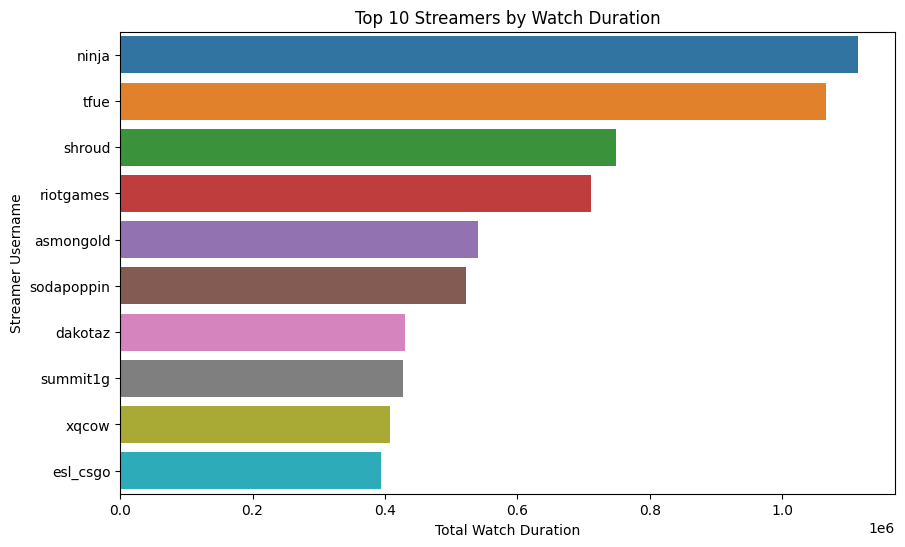

In [18]:
watch_duration_per_streamer = data.groupby('Streamer Username')['Watch Duration'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=watch_duration_per_streamer.head(10).values, y=watch_duration_per_streamer.head(10).index)
plt.xlabel('Total Watch Duration')
plt.ylabel('Streamer Username')
plt.title('Top 10 Streamers by Watch Duration')
plt.show()


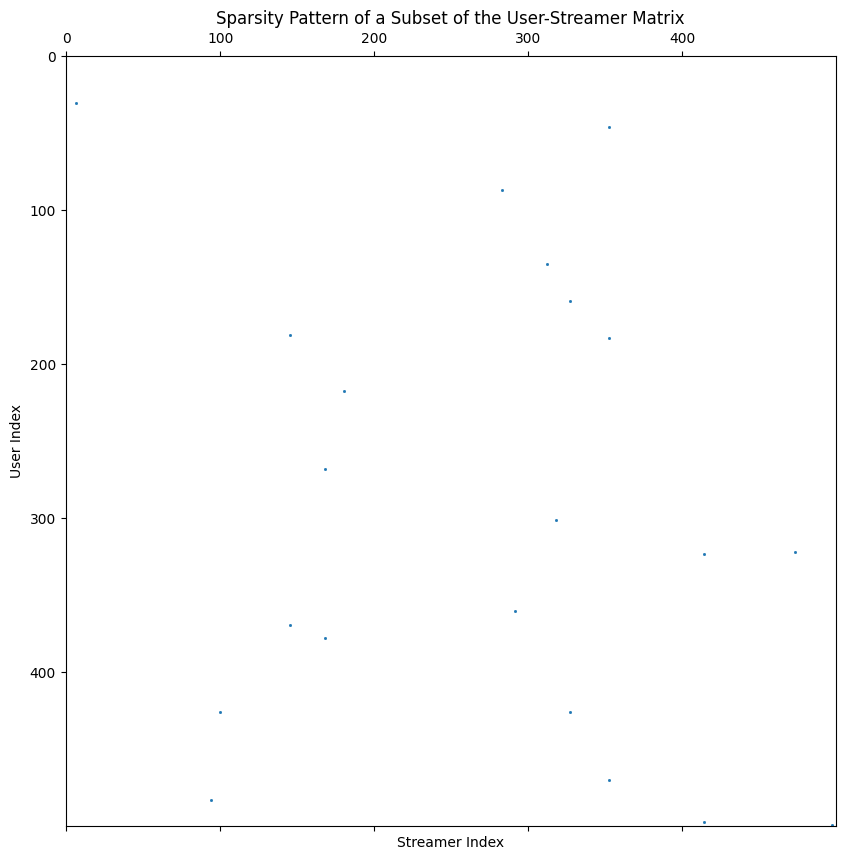

In [19]:

plt.figure(figsize=(10, 10))
plt.spy(sparse_matrix[:500, :500], markersize=1)  # Adjust the slicing based on your dataset
plt.title('Sparsity Pattern of a Subset of the User-Streamer Matrix')
plt.xlabel('Streamer Index')
plt.ylabel('User Index')
plt.show()


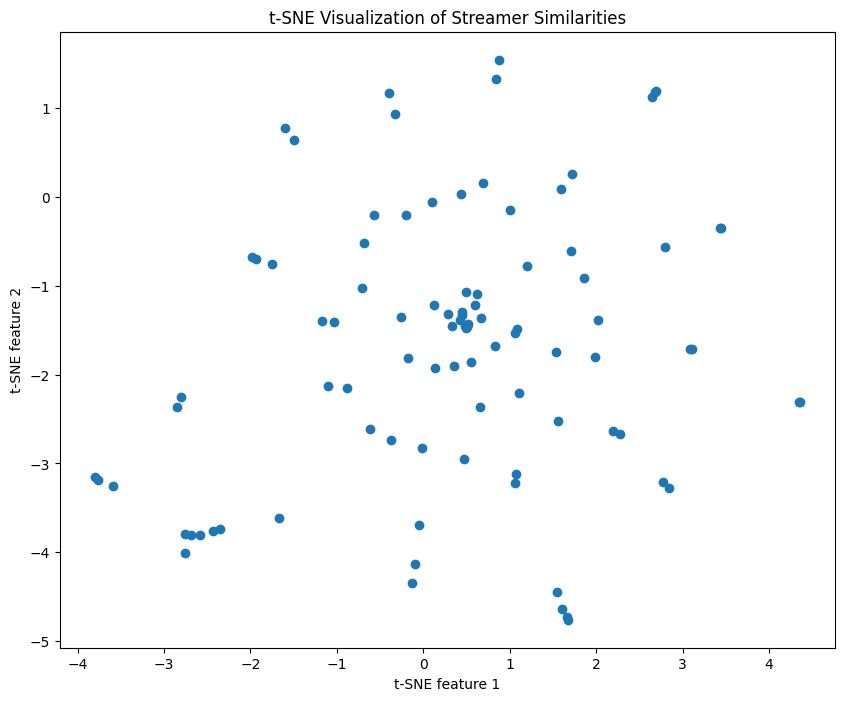

In [20]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
subset_size = 100  # Adjust based on your dataset's size
tsne_results = tsne.fit_transform(similarity_matrix[:subset_size].toarray())

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Streamer Similarities')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


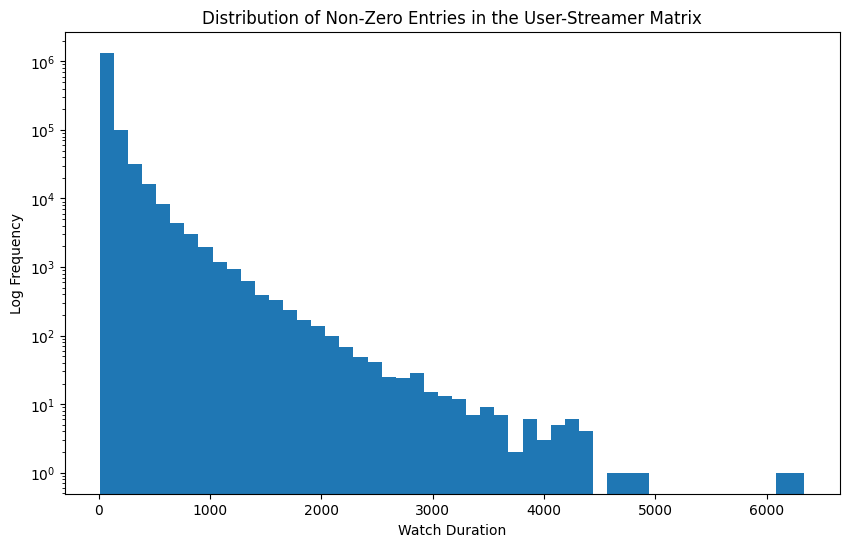

In [21]:

# Histogram of non-zero entries in the sparse matrix
plt.figure(figsize=(10, 6))
plt.hist(sparse_matrix.data, bins=50, log=True)
plt.title('Distribution of Non-Zero Entries in the User-Streamer Matrix')
plt.xlabel('Watch Duration')
plt.ylabel('Log Frequency')
plt.show()


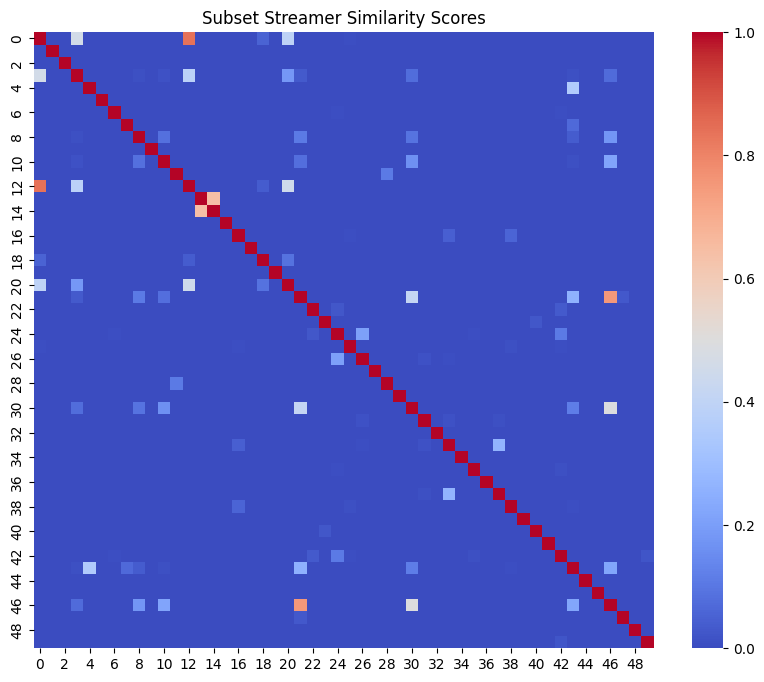

In [22]:
# Select a fixed subset of the similarity matrix for visualization
subset_size = 50  # Adjust this number based on your dataset's size
subset_similarity_matrix = similarity_matrix[:subset_size, :subset_size]

# Convert the subset of the similarity matrix to a DataFrame
subset_similarity_df = pd.DataFrame(subset_similarity_matrix.toarray())

# Plotting a heatmap of the subset similarity scores
plt.figure(figsize=(10, 8))
sns.heatmap(subset_similarity_df, cmap='coolwarm', annot=False)
plt.title('Subset Streamer Similarity Scores')
plt.show()